In [1]:
#Exploring logistic classification

In [2]:
using Random
using Flux
using Flux: logitcrossentropy, onehot, onecold
using Plots

function classification_regression_fit(X, Y, l, r, lambda, kappa; numiters = 500)
    #     Inputs:
    #         X: input data
    #         Y: output data
    #         l: l(yhat, y, kappa)
    #         r: r(theta)
    #         lambda: regularization hyper-parameter
    #         numiters (optional): number of iterations
        
        data = zip(eachrow(X), eachrow(Y))
        n,d = size(X)
        theta = zeros(d)
        predicty(x) = theta'*x
        loss(x, y) = l(predicty(x), y[1], kappa) + lambda*r(theta)
        cost(x,y) = loss(x,y) + lambda*r(theta)
        risk() = sum((cost(d...) for d in data))/n
        opt = Flux.ADAGrad()
        losses = []
        tracker() = push!(losses, risk())
        Flux.@epochs numiters Flux.train!(loss, Flux.params(theta), data, opt, cb = Flux.throttle(tracker,10))
        return theta
    end

classification_regression_fit (generic function with 1 method)

In [2]:
Random.seed!(0)

include("readclassjson.jl")
data = readclassjson("covid_symptoms.json")

U = data["U"]
v = data["v"]

U = hcat(ones(5434), U)

df = hcat(U, v)
df = df[shuffle(1:end), :]

5434×22 Matrix{Float64}:
 1.0  1.0  1.0  1.0  1.0  0.0  1.0  …  1.0  1.0  0.0  0.0  0.0  0.0   1.0
 1.0  1.0  1.0  1.0  0.0  0.0  1.0     1.0  0.0  0.0  1.0  0.0  0.0   1.0
 1.0  1.0  1.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  -1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  0.0  1.0  0.0  0.0  0.0   1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0     1.0  1.0  1.0  0.0  0.0  0.0   1.0
 1.0  1.0  0.0  1.0  1.0  0.0  1.0  …  0.0  0.0  0.0  0.0  0.0  0.0   1.0
 1.0  1.0  0.0  1.0  0.0  0.0  1.0     1.0  0.0  0.0  0.0  0.0  0.0   1.0
 1.0  1.0  1.0  0.0  0.0  1.0  0.0     1.0  1.0  0.0  0.0  0.0  0.0   1.0
 1.0  1.0  0.0  1.0  1.0  0.0  0.0     1.0  1.0  0.0  0.0  0.0  0.0   1.0
 1.0  1.0  1.0  0.0  1.0  1.0  1.0     1.0  1.0  0.0  0.0  0.0  0.0   1.0
 1.0  0.0  1.0  1.0  1.0  0.0  1.0  …  0.0  1.0  0.0  1.0  0.0  0.0   1.0
 1.0  1.0  1.0  1.0  1.0  0.0  0.0     1.0  0.0  1.0  1.0  0.0  0.0   1.0
 1.0  1.0  0.0  1.0  1.0  0.0  1.0     0.0  0.0  1.0  0.0  0.0  0.0   1.0
 ⋮           

In [3]:
U_train = df[1:4890, 1:21]
v_train = df[1:4890, 22]

U_eval = df[4891:5434, 1:21]
v_eval = df[4891:5434, 22]

544-element Vector{Float64}:
  1.0
  1.0
  1.0
  1.0
 -1.0
  1.0
  1.0
 -1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  ⋮
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
 -1.0
  1.0
  1.0

In [4]:
using LinearAlgebra

lambda = 0.01
r(theta) = norm(theta, 2)^2
kappas = 10 .^ range(-2,1,length=10)

function l(yhat, y, kappa)
    if y == -1
        return 1 + yhat
    elseif y == 1
        return kappa * (1 - yhat)
    end
end

function normalize(y)
    if y == -1
        return 1
    elseif y == 1
        return 2
    end
end

function confusionMatrix(y_hat, y)
    cm = zeros(2, 2)
    for i in 1:size(y, 1)
        row = normalize(y_hat[i])
        col = normalize(y[i])
        cm[row, col] += 1
    end
    return cm
end

confusionMatrix (generic function with 1 method)

In [15]:
accuracies = zeros(10)
fps = zeros(10)
fns = zeros(10)

for i in 1:10
    theta = classification_regression_fit(U_train, v_train, l, r, lambda, kappas[i])
    v_eval_hat = U_eval * theta
    cm = confusionMatrix(sign.(v_eval_hat), v_eval)
    accuracies[i] = cm[1, 1] + cm[2, 2]
    fns[i] = cm[1, 2]
    fps[i] = cm[2, 1]
end

┌ Info: Epoch 1
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 2
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 3
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 4
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 5
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 6
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 7
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 8
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 9
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 10
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 11
└ @ Main C:\Users\surface\.julia

┌ Info: Epoch 104
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 105
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 106
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 107
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 108
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 109
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 110
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 111
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 112
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 113
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 114
└ @ Main C:\

┌ Info: Epoch 206
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 207
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 208
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 209
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 210
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 211
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 212
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 213
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 214
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 215
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 216
└ @ Main C:\

┌ Info: Epoch 308
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 309
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 310
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 311
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 312
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 313
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 314
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 315
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 316
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 317
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 318
└ @ Main C:\

┌ Info: Epoch 410
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 411
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 412
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 413
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 414
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 415
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 416
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 417
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 418
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 419
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 420
└ @ Main C:\

┌ Info: Epoch 12
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 13
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 14
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 15
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 16
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 17
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 18
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 19
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 20
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 21
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 22
└ @ Main C:\Users\surfa

┌ Info: Epoch 115
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 116
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 117
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 118
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 119
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 120
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 121
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 122
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 123
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 124
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 125
└ @ Main C:\

┌ Info: Epoch 217
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 218
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 219
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 220
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 221
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 222
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 223
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 224
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 225
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 226
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 227
└ @ Main C:\

┌ Info: Epoch 319
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 320
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 321
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 322
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 323
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 324
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 325
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 326
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 327
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 328
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 329
└ @ Main C:\

┌ Info: Epoch 421
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 422
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 423
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 424
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 425
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 426
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 427
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 428
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 429
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 430
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 431
└ @ Main C:\

┌ Info: Epoch 23
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 24
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 25
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 26
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 27
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 28
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 29
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 30
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 31
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 32
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 33
└ @ Main C:\Users\surfa

┌ Info: Epoch 126
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 127
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 128
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 129
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 130
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 131
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 132
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 133
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 134
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 135
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 136
└ @ Main C:\

┌ Info: Epoch 228
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 229
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 230
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 231
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 232
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 233
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 234
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 235
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 236
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 237
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 238
└ @ Main C:\

┌ Info: Epoch 330
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 331
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 332
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 333
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 334
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 335
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 336
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 337
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 338
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 339
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 340
└ @ Main C:\

┌ Info: Epoch 432
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 433
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 434
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 435
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 436
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 437
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 438
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 439
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 440
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 441
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 442
└ @ Main C:\

┌ Info: Epoch 34
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 35
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 36
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 37
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 38
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 39
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 40
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 41
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 42
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 43
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 44
└ @ Main C:\Users\surfa

┌ Info: Epoch 137
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 138
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 139
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 140
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 141
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 142
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 143
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 144
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 145
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 146
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 147
└ @ Main C:\

┌ Info: Epoch 239
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 240
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 241
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 242
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 243
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 244
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 245
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 246
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 247
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 248
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 249
└ @ Main C:\

┌ Info: Epoch 341
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 342
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 343
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 344
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 345
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 346
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 347
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 348
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 349
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 350
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 351
└ @ Main C:\

┌ Info: Epoch 443
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 444
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 445
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 446
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 447
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 448
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 449
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 450
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 451
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 452
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 453
└ @ Main C:\

┌ Info: Epoch 45
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 46
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 47
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 48
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 49
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 50
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 51
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 52
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 53
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 54
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 55
└ @ Main C:\Users\surfa

┌ Info: Epoch 147
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 148
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 149
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 150
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 151
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 152
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 153
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 154
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 155
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 156
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 157
└ @ Main C:\

┌ Info: Epoch 249
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 250
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 251
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 252
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 253
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 254
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 255
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 256
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 257
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 258
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 259
└ @ Main C:\

┌ Info: Epoch 351
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 352
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 353
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 354
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 355
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 356
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 357
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 358
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 359
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 360
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 361
└ @ Main C:\

┌ Info: Epoch 453
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 454
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 455
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 456
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 457
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 458
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 459
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 460
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 461
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 462
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 463
└ @ Main C:\

┌ Info: Epoch 56
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 57
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 58
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 59
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 60
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 61
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 62
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 63
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 64
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 65
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 66
└ @ Main C:\Users\surfa

┌ Info: Epoch 158
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 159
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 160
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 161
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 162
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 163
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 164
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 165
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 166
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 167
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 168
└ @ Main C:\

┌ Info: Epoch 260
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 261
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 262
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 263
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 264
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 265
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 266
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 267
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 268
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 269
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 270
└ @ Main C:\

┌ Info: Epoch 362
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 363
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 364
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 365
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 366
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 367
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 368
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 369
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 370
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 371
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 372
└ @ Main C:\

┌ Info: Epoch 464
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 465
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 466
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 467
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 468
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 469
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 470
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 471
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 472
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 473
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 474
└ @ Main C:\

┌ Info: Epoch 67
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 68
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 69
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 70
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 71
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 72
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 73
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 74
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 75
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 76
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 77
└ @ Main C:\Users\surfa

┌ Info: Epoch 169
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 170
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 171
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 172
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 173
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 174
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 175
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 176
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 177
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 178
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 179
└ @ Main C:\

┌ Info: Epoch 271
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 272
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 273
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 274
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 275
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 276
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 277
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 278
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 279
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 280
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 281
└ @ Main C:\

┌ Info: Epoch 373
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 374
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 375
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 376
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 377
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 378
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 379
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 380
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 381
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 382
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 383
└ @ Main C:\

┌ Info: Epoch 475
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 476
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 477
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 478
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 479
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 480
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 481
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 482
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 483
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 484
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 485
└ @ Main C:\

┌ Info: Epoch 78
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 79
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 80
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 81
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 82
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 83
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 84
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 85
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 86
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 87
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 88
└ @ Main C:\Users\surfa

┌ Info: Epoch 180
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 181
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 182
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 183
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 184
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 185
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 186
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 187
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 188
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 189
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 190
└ @ Main C:\

┌ Info: Epoch 282
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 283
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 284
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 285
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 286
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 287
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 288
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 289
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 290
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 291
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 292
└ @ Main C:\

┌ Info: Epoch 384
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 385
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 386
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 387
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 388
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 389
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 390
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 391
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 392
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 393
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 394
└ @ Main C:\

┌ Info: Epoch 486
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 487
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 488
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 489
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 490
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 491
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 492
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 493
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 494
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 495
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 496
└ @ Main C:\

┌ Info: Epoch 89
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 90
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 91
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 92
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 93
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 94
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 95
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 96
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 97
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 98
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 99
└ @ Main C:\Users\surfa

┌ Info: Epoch 191
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 192
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 193
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 194
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 195
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 196
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 197
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 198
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 199
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 200
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 201
└ @ Main C:\

┌ Info: Epoch 293
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 294
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 295
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 296
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 297
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 298
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 299
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 300
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 301
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 302
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 303
└ @ Main C:\

┌ Info: Epoch 395
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 396
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 397
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 398
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 399
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 400
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 401
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 402
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 403
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 404
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 405
└ @ Main C:\

┌ Info: Epoch 497
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 498
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 499
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 500
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 1
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 2
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 3
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 4
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 5
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 6
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 7
└ @ Main C:\Users\surface\

┌ Info: Epoch 100
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 101
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 102
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 103
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 104
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 105
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 106
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 107
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 108
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 109
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 110
└ @ Main C:\

┌ Info: Epoch 202
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 203
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 204
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 205
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 206
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 207
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 208
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 209
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 210
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 211
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 212
└ @ Main C:\

┌ Info: Epoch 304
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 305
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 306
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 307
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 308
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 309
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 310
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 311
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 312
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 313
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 314
└ @ Main C:\

┌ Info: Epoch 406
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 407
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 408
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 409
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 410
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 411
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 412
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 413
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 414
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 415
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 416
└ @ Main C:\

In [17]:
accuracies = accuracies / size(v_eval, 1)
fps = fps / size(v_eval, 1)
fns = fns / size(v_eval, 1)

10-element Vector{Float64}:
 0.78125
 0.78125
 0.78125
 0.78125
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [40]:
println(kappas)
println(accuracies)
println(fps)
println(fns)

[0.01, 0.021544346900318832, 0.046415888336127795, 0.1, 0.2154434690031884, 0.4641588833612779, 1.0, 2.154434690031884, 4.641588833612778, 10.0]
[0.21875, 0.21875, 0.21875, 0.21875, 0.8235294117647058, 0.78125, 0.78125, 0.78125, 0.78125, 0.78125]
[0.0, 0.0, 0.0, 0.0, 0.17647058823529413, 0.21875, 0.21875, 0.21875, 0.21875, 0.21875]
[0.78125, 0.78125, 0.78125, 0.78125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


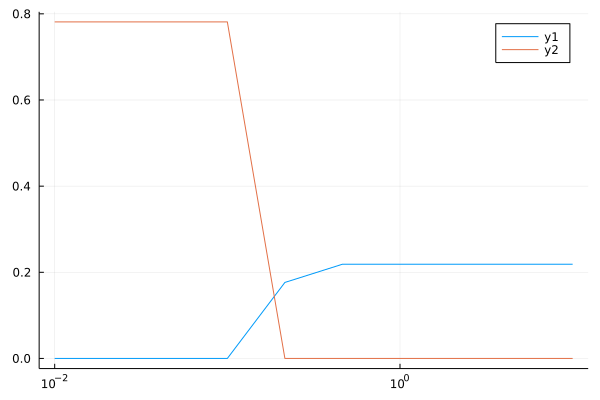

In [38]:
using Plots
plot(kappas, fps, xaxis=:log)
plot!(kappas, fns, xaxis=:log)

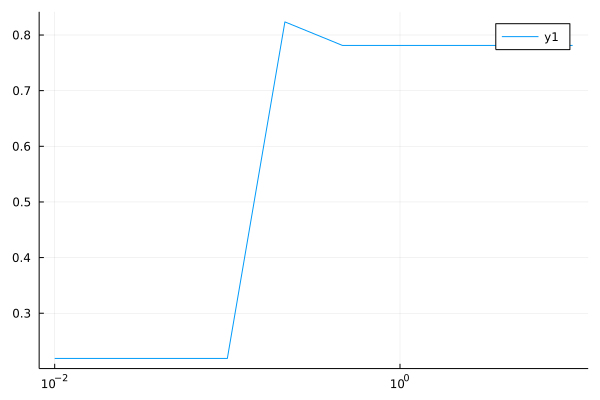

In [39]:
plot(kappas, accuracies, xaxis=:log)

In [41]:
theta = classification_regression_fit(U_train, v_train, l, r, lambda, kappas[argmax(accuracies)])
v_eval_hat = U_eval * theta

┌ Info: Epoch 1
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 2
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 3
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 4
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 5
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 6
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 7
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 8
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 9
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 10
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 11
└ @ Main C:\Users\surface\.julia

┌ Info: Epoch 104
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 105
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 106
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 107
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 108
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 109
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 110
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 111
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 112
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 113
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 114
└ @ Main C:\

┌ Info: Epoch 206
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 207
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 208
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 209
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 210
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 211
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 212
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 213
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 214
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 215
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 216
└ @ Main C:\

┌ Info: Epoch 308
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 309
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 310
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 311
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 312
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 313
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 314
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 315
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 316
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 317
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 318
└ @ Main C:\

┌ Info: Epoch 410
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 411
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 412
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 413
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 414
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 415
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 416
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 417
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 418
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 419
└ @ Main C:\Users\surface\.julia\packages\Flux\6Q5r4\src\optimise\train.jl:154
┌ Info: Epoch 420
└ @ Main C:\

544-element Vector{Float64}:
 17.886707438973403
 11.375799868952548
 22.775390467475084
 14.376909720040194
  9.007137496111168
 18.325629198063343
 13.862888379253262
  9.007137496111168
 30.374452944188267
 21.033422245257828
 17.1510200685667
 12.821388643457285
 17.59646232843305
  ⋮
 30.542603109050876
 22.64551842255831
 23.69925022416948
 11.375799868952548
 19.09830437343192
 27.294490768186105
 23.10294776400569
 17.47852553717758
  9.163680364617015
  6.056288452388393
 18.65852268027266
 20.744988613571564

In [43]:
# The best classifier (highest accuracy) is kappa = 0.2154
println(kappas[argmax(accuracies)])
println(accuracies[argmax(accuracies)])

cm = confusionMatrix(sign.(v_eval_hat), v_eval)
cm = transpose(cm)
display(cm)

0.2154434690031884
0.8235294117647058


2×2 transpose(::Matrix{Float64}) with eltype Float64:
 23.0   96.0
  0.0  425.0